In [16]:
# Imports
import torch
import torch.nn as nn
import torch.optim  as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Image Size
imgSize = 112

# Transformations
# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [3]:
# hyperparameters
BATCH_SIZE = 64
epochs = 30
learning_rate = 0.001

In [4]:
path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

# Reading data
trainData = datasets.ImageFolder(root = path, transform = transformer)
testData = datasets.ImageFolder(root = valPath, transform = valTransformer)

train_loader = DataLoader(dataset=trainData,batch_size= BATCH_SIZE, shuffle= True)
test_loader = DataLoader(dataset=testData, batch_size= BATCH_SIZE, shuffle= False)

In [5]:
model = torchvision.models.efficientnet_b7(weights= torchvision.models.EfficientNet_B7_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(2560, 2)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 155MB/s]  


Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=2, bias=True)
)


In [6]:
# Send model to gpu
print(device)
model.to(device)

# Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 8, verbose=True, factor=0.1)

cuda


In [7]:
def check_accuracy(loader, model, Train= True):
    if Train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on test data')
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    acc = float(num_correct/float(num_samples))
    print(f'{num_correct}/{num_samples} with accuracy {float(num_correct/float(num_samples))*100:.2f}')
    model.train()
    return acc

In [8]:
# Early Stopping
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

In [9]:
for epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(enumerate(train_loader), total= len(train_loader), leave= False)
    for batch_idx, (data, targets) in loop:
        # Send data to device
        data = data.to(device)
        targets = targets.to(device)
        
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        
        #log
        runningLoss += loss.item()
        
        #otimizer
        optimizer.step()
        
        # update progress bar
        loop.set_description(f'Epoch [{epoch}/{epochs}]')
        loop.set_postfix(loss = loss.item())
    
    trainLoss= runningLoss/len(train_loader)
    
    if trainLoss < bestLoss - minDelta:
        bestLoss = trainLoss
        currentPatience = 0
    else:
        currentPatience += 1
    if currentPatience >= patience:
        print('Early stopping triggered.')
        break
    
    scheduler.step(trainLoss)
    check_accuracy(train_loader, model, Train=True)

Checking accuracy on training data
10637/11879 with accuracy 89.54


Checking accuracy on training data
10660/11879 with accuracy 89.74


Checking accuracy on training data
10953/11879 with accuracy 92.20


Checking accuracy on training data
10955/11879 with accuracy 92.22


Checking accuracy on training data
11232/11879 with accuracy 94.55


Checking accuracy on training data
11229/11879 with accuracy 94.53


Checking accuracy on training data
11234/11879 with accuracy 94.57


Checking accuracy on training data
11392/11879 with accuracy 95.90


Checking accuracy on training data
11314/11879 with accuracy 95.24


Checking accuracy on training data
11382/11879 with accuracy 95.82


Checking accuracy on training data
11265/11879 with accuracy 94.83


Checking accuracy on training data
11496/11879 with accuracy 96.78


Checking accuracy on training data
11541/11879 with accuracy 97.15


Checking accuracy on training data
11520/11879 with accuracy 96.98


Checking accuracy on training data
11603/11879 with accuracy 97.68


Checking accuracy on training data
11594/11879 with accuracy 97.60


Checking accuracy on training data
11582/11879 with accuracy 97.50


Checking accuracy on training data
11643/11879 with accuracy 98.01


Checking accuracy on training data
11617/11879 with accuracy 97.79


Checking accuracy on training data
11641/11879 with accuracy 98.00


Checking accuracy on training data
11622/11879 with accuracy 97.84


Checking accuracy on training data
11623/11879 with accuracy 97.84


Checking accuracy on training data
11593/11879 with accuracy 97.59


Checking accuracy on training data
11740/11879 with accuracy 98.83


Checking accuracy on training data
11639/11879 with accuracy 97.98


Checking accuracy on training data
11664/11879 with accuracy 98.19


Checking accuracy on training data
11733/11879 with accuracy 98.77


Checking accuracy on training data
11634/11879 with accuracy 97.94


Checking accuracy on training data
11654/11879 with accuracy 98.11


Early stopping triggered.


In [11]:
check_accuracy(train_loader, model, Train= True)
check_accuracy(test_loader, model, Train= False)

Checking accuracy on training data
11739/11879 with accuracy 98.82
Checking accuracy on test data
1921/2000 with accuracy 96.05


0.9605000615119934

In [23]:
def calculate_classification_metrics(loader, model):
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            true.extend(y.to('cpu'))
            preds.extend(predictions.to('cpu'))
    print(sklearn.metrics.classification_report(true, preds, digits=5))
    conf_matrix = confusion_matrix(true, preds)
    sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()

              precision    recall  f1-score   support

           0    0.95549   0.96600   0.96072      1000
           1    0.96562   0.95500   0.96028      1000

    accuracy                        0.96050      2000
   macro avg    0.96056   0.96050   0.96050      2000
weighted avg    0.96056   0.96050   0.96050      2000



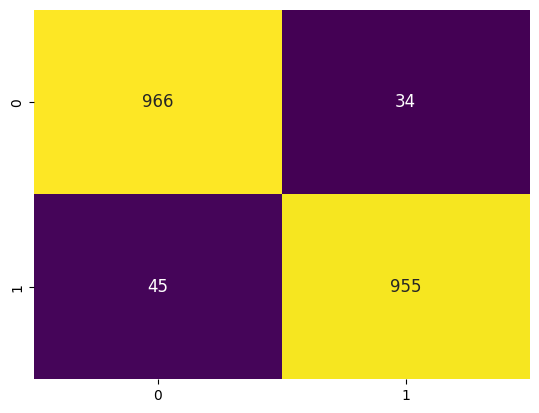

In [24]:
calculate_classification_metrics(test_loader, model)